In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, MDS, LocallyLinearEmbedding

sns.set(style = 'white', font_scale=1.5)

In [2]:
import sys
sys.path.insert(0, '/home/was966/Research/mims-compass/')
from compass.tokenizer import CONCEPT_palette
CONCEPT_palette = pd.DataFrame([CONCEPT_palette]).T.reset_index().sort_index(ascending=False).set_index('index')[0].to_dict()

hue_order = CONCEPT_palette.keys()
hue_color = CONCEPT_palette.values()

In [4]:
CONCEPT_palette

{'CANCER': '#708090',
 'Reference': '#d3d3d3',
 'Genome_integrity': '#e452ff',
 'Cell_proliferation': '#bf03b8',
 'TLS': '#9c3b4f',
 'Cytokine': '#ffa52f',
 'TGFb_pathway': '#db6d01',
 'IFNg_pathway': '#eb0077',
 'Apoptosis_pathway': '#c36690',
 'Pneumocyte': '#5d7e66',
 'Pancreatic': '#573b00',
 'Hepatocyte': '#004b00',
 'Adipocyte': '#5900a3',
 'Mesothelial': '#645474',
 'Epithelial': '#380000',
 'Endothelial': '#93b8b5',
 'Fibroblast': '#5d363b',
 'Pericyte': '#005659',
 'Stroma': '#00fdcf',
 'Stem': '#97ff00',
 'Platelet': '#fdf490',
 'Erythrocyte': '#cac300',
 'Mast': '#fdbfff',
 'Granulocyte': '#a17569',
 'Myeloid': '#bde6bf',
 'Monocyte': '#a57bb8',
 'Macrophage': '#ff7ed1',
 'pDC': '#8e7900',
 'cDC': '#9e4b00',
 'Innate_lymphoid_cell': '#edb8b8',
 'NKcell': '#ff7266',
 'Treg': '#bcb6ff',
 'Immune_checkpoint': '#8c3bff',
 'Exhausted_Tcell': '#6b004f',
 'Cytotoxic_Tcell': '#d60000',
 'Tcell_general': '#00acc6',
 'Naive_Tcell': '#0774d8',
 'Memory_Tcell': '#2f5282',
 'CD8_Tcell': 

In [42]:
dfc = pd.read_csv('../01_extract_readout//TCGA/04_features_celltype.csv', index_col=0)
dfl = pd.read_csv('../01_extract_readout//TCGA/00_clinical_label_orignal.csv', index_col=0)

tcga = dfc['bcr_patient_barcode'].map(dfl['cancer_type'].apply(lambda x:x.split('-')[1])).to_frame(name='cancer_type')
tcga['domain'] = 'TCGA'
tcga_dfc = tcga.join(dfc)

dfc = pd.read_csv('../01_extract_readout//ITRP/04_features_celltype.csv', index_col=0)
dfc = dfc.rename(columns = {'Index':'bcr_patient_barcode'})

dfl = pd.read_csv('../01_extract_readout//ITRP/00_clinical_label.csv', index_col=0)
itrp = dfc['bcr_patient_barcode'].map(dfl['cancer_type']).to_frame(name='cancer_type')

itrp['domain'] = 'ITRP'
itrp_dfc = itrp.join(dfc)

dfc = tcga_dfc._append(itrp_dfc)

In [43]:
data = dfc[dfc.columns[-32:]]
mp = PCA(n_components = 2, svd_solver='full') #
pca2d = mp.fit_transform(data)
df_pca2d  = pd.DataFrame(pca2d, index=data.index, columns = ['PCA1', 'PCA2'])

In [44]:
data = tcga_dfc[tcga_dfc.columns[-32:]].values
mp = PCA(n_components = 2) #
mp = mp.fit(data)
df2d = mp.transform(dfc[dfc.columns[-32:]].values)
df_pca2d  = pd.DataFrame(pca2d, index=dfc.index, columns = ['PCA1', 'PCA2'])

In [ ]:
mp = UMAP(n_components = 2, n_neighbors = 200, n_epochs = 1000, min_dist=0.8, random_state = 42,  verbose=1 ) # metric='cosine', 
mp = mp.fit(data)
umap2d = mp.transform(dfc[dfc.columns[-32:]].values)
df_umap2d  = pd.DataFrame(umap2d, index=dfc.index, columns = ['UMAP1', 'UMAP2'])

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.8, n_epochs=1000, n_neighbors=200, random_state=42, verbose=1)
Thu Jun  6 00:18:56 2024 Construct fuzzy simplicial set
Thu Jun  6 00:18:56 2024 Finding Nearest Neighbors
Thu Jun  6 00:18:56 2024 Building RP forest with 38 trees
Thu Jun  6 00:18:57 2024 NN descent for 19 iterations


In [ ]:
df2d = dfc[['cancer_type', 'domain', 'bcr_patient_barcode', 'feature_name']].join(df_pca2d).join(df_umap2d)

In [ ]:
df2d.to_csv('celltype_space_2.csv.gzip',compression ='gzip')

In [ ]:
df2d.head()

In [ ]:
df2d = pd.read_csv('celltype_space_2.csv.gzip', index_col=0, compression = 'gzip')

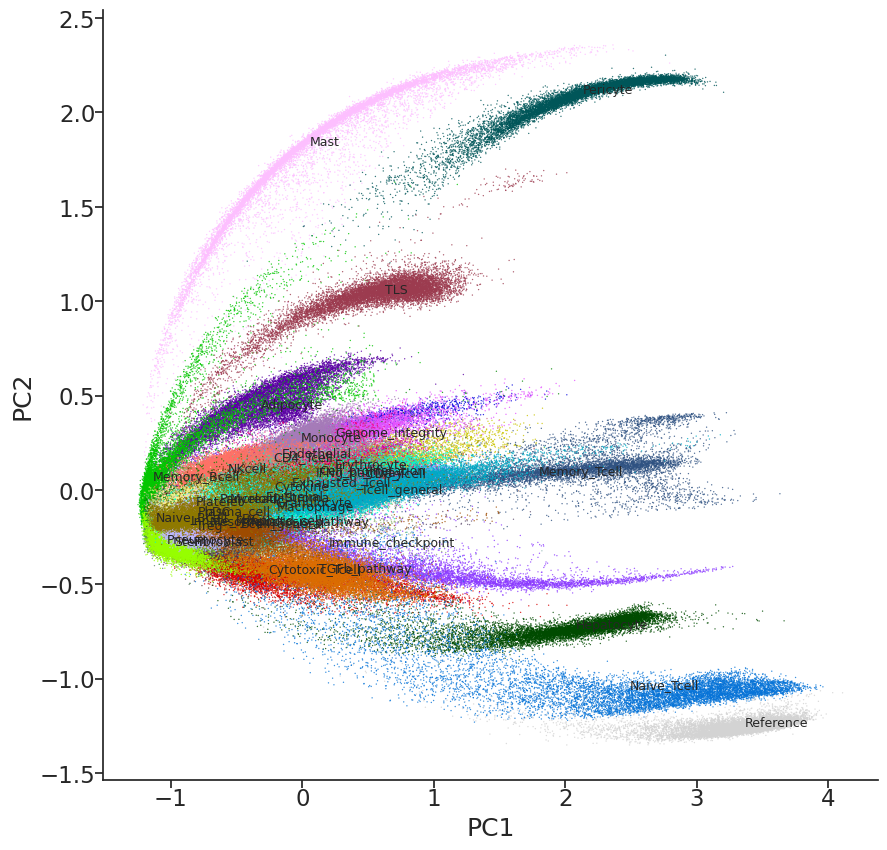

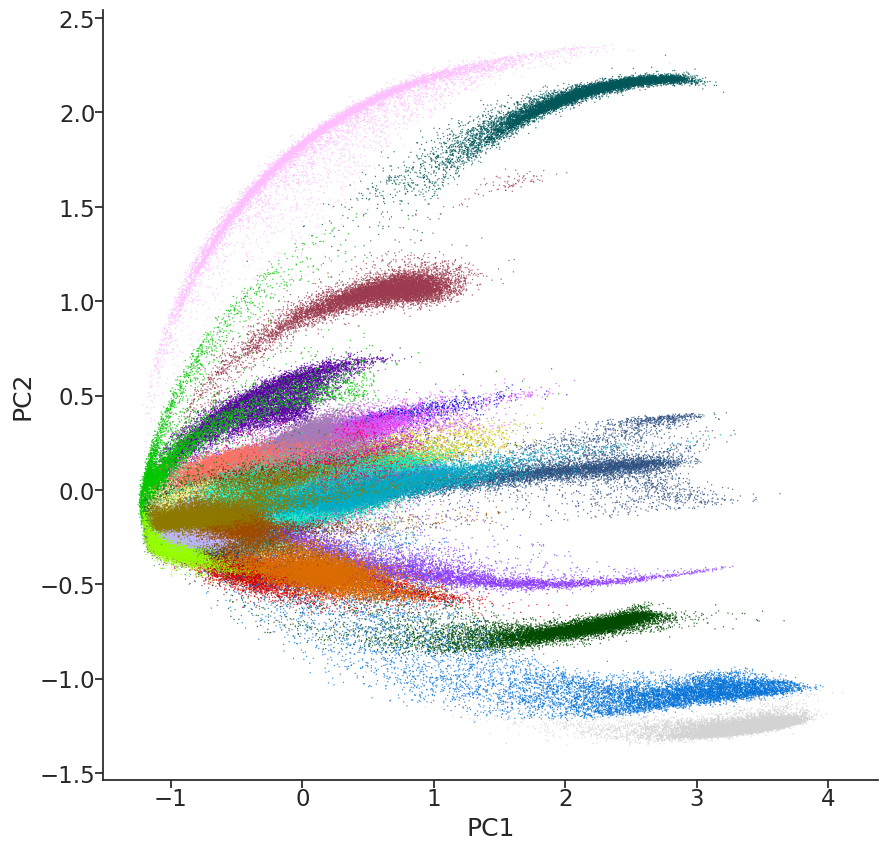

In [60]:
dfp = df2d[df2d.domain == 'TCGA']

fig, ax = plt.subplots(figsize=(10, 10))

x = 'PCA1'
y = 'PCA2'
hue = 'feature_name'

sns.scatterplot(data = dfp, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 1, 
                 ax=ax, legend=False)

mean = dfp.groupby(hue)[[x,y]].median()
for name in mean.index:
    s = mean.loc[name]
    ax.text(s[x], s[y], name,  fontdict={'fontsize':9})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('cell_TCGA_PCA_labelled.pdf')
fig.savefig('cell_TCGA_PCA_labelled.svg')


dfp = df2d[df2d.domain == 'TCGA']

fig, ax = plt.subplots(figsize=(10, 10))

x = 'PCA1'
y = 'PCA2'
hue = 'feature_name'

sns.scatterplot(data = dfp, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 1, 
                 ax=ax, legend=False)

# mean = dfp.groupby(hue)[[x,y]].median()
# for name in mean.index:
#     s = mean.loc[name]
#     ax.text(s[x], s[y], name,  fontdict={'fontsize':9})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('cell_TCGA_PCA_unlabelled.pdf', bbox_inches ='tight')
fig.savefig('cell_TCGA_PCA_unlabelled.svg', bbox_inches ='tight')

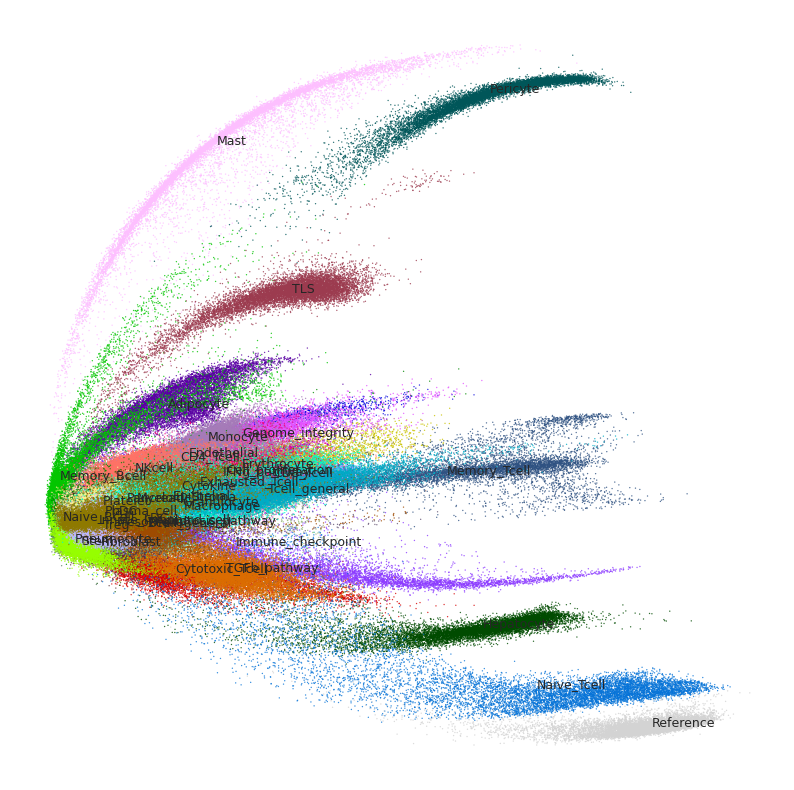

In [61]:
dfp = df2d[df2d.domain == 'TCGA']

fig, ax = plt.subplots(figsize=(10, 10))

x = 'PCA1'
y = 'PCA2'
hue = 'feature_name'

sns.scatterplot(data = dfp, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 1, 
                 ax=ax, legend=False)

mean = dfp.groupby(hue)[[x,y]].median()
for name in mean.index:
    s = mean.loc[name]
    ax.text(s[x], s[y], name,  fontdict={'fontsize':9})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('')

plt.axis('off')

fig.savefig('cell_TCGA_PCA_unlabelled.jpg', bbox_inches ='tight', dpi=1000)

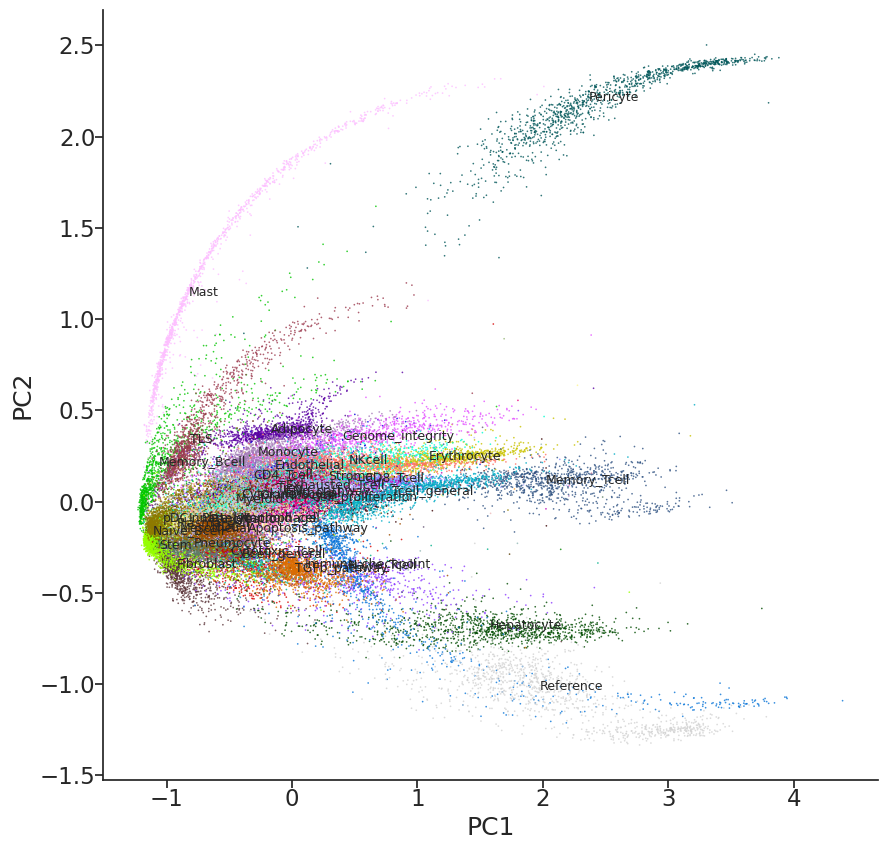

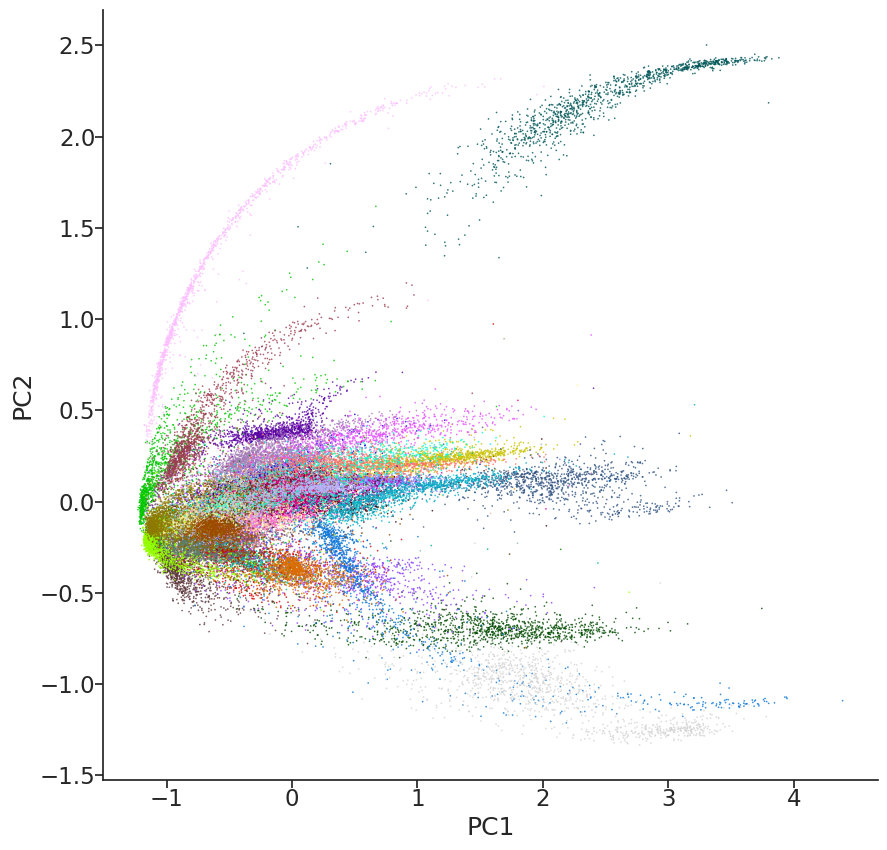

In [62]:
dfp = df2d[df2d.domain == 'ITRP']

fig, ax = plt.subplots(figsize=(10, 10))

x = 'PCA1'
y = 'PCA2'
hue = 'feature_name'

sns.scatterplot(data = dfp, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s =1.5, 
                 ax=ax, legend=False)

mean = dfp.groupby(hue)[[x,y]].median()
for name in mean.index:
    s = mean.loc[name]
    ax.text(s[x], s[y], name,  fontdict={'fontsize':9})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


fig.savefig('cell_ITRP_PCA_labelled.pdf')



dfp = df2d[df2d.domain == 'ITRP']

fig, ax = plt.subplots(figsize=(10, 10))

x = 'PCA1'
y = 'PCA2'
hue = 'feature_name'

sns.scatterplot(data = dfp, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s =1.5, 
                 ax=ax, legend=False)

# mean = dfp.groupby(hue)[[x,y]].median()
# for name in mean.index:
#     s = mean.loc[name]
#     ax.text(s[x], s[y], name,  fontdict={'fontsize':9})
ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('cell_ITRP_PCA_unlabelled.pdf', bbox_inches ='tight')
fig.savefig('cell_ITRP_PCA_unlabelled.svg', bbox_inches ='tight')

In [63]:
ls

00_define_celltye_color.ipynb         celltype_statistic.tsv
01_celltype_scores.ipynb              color_celltype.pdf
02_celltype_features_fit_trans.ipynb  color_color2pick.pdf
02_celltype_features.ipynb            color_geneset.pdf
03_geneset_features.ipynb             Concept_TCGA_Cytotoxic_Tcell.pdf
04_plot_genes_upset.ipynb             Concept_TCGA_Macrophage.pdf
cell_ITRP_PCA_labelled.pdf            Concept_TCGA_Mast.pdf
cell_ITRP_PCA_unlabelled.pdf          Concept_TCGA_Naive_Tcell.pdf
cell_ITRP_PCA_unlabelled.svg          Concept_TCGA_Reference.pdf
cell_ITRP_UMAP_labelled.pdf           geneset_ITRP_PCA_labelled.pdf
cell_overlay_PCA_labelled.jpg         geneset_ITRP_PCA_unlabelled.pdf
cell_overlay_PCA_labelled.pdf         geneset_ITRP_UMAP_labelled.pdf
cell_overlay_UMAP_labelled.pdf        geneset_overlay_PCA_labelled.pdf
cell_overlay_UMAP_unlabelled.jpg      geneset_overlay_UMAP_labelled.pdf
cell_overlay_UMAP_unlabelled.pdf      geneset_space.csv
cell_TCGA_PCA_labelled.pdf      

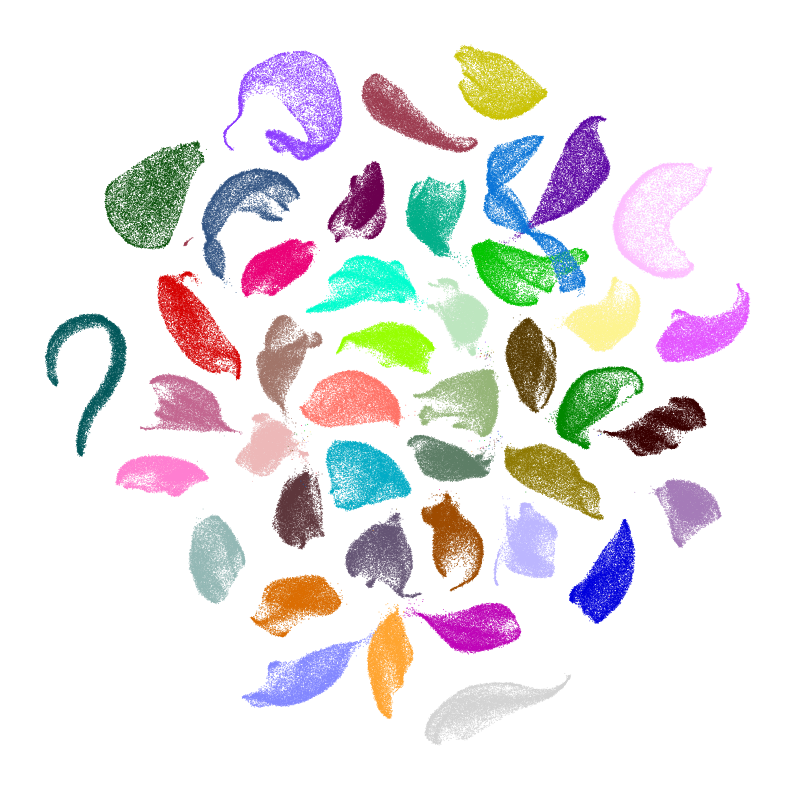

In [64]:
dfp = df2d[df2d.domain == 'TCGA']
fig, ax = plt.subplots(figsize=(10, 10))

x = 'UMAP1'
y = 'UMAP2'
hue = 'feature_name'

sns.scatterplot(data = dfp, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 0.5, 
                 ax=ax, legend=False)

# mean = dfp.groupby(hue)[[x,y]].median()
# for name in mean.index:
#     s = mean.loc[name]
#     ax.text(s[x], s[y], name,  fontdict={'fontsize':10})

# ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('')
ax.set_ylabel('')

plt.axis('off')

fig.savefig('cell_TCGA_UMAP_unlabelled.pdf', bbox_inches ='tight')
fig.savefig('cell_TCGA_UMAP_unlabelled.jpg', bbox_inches ='tight', dpi=1000)

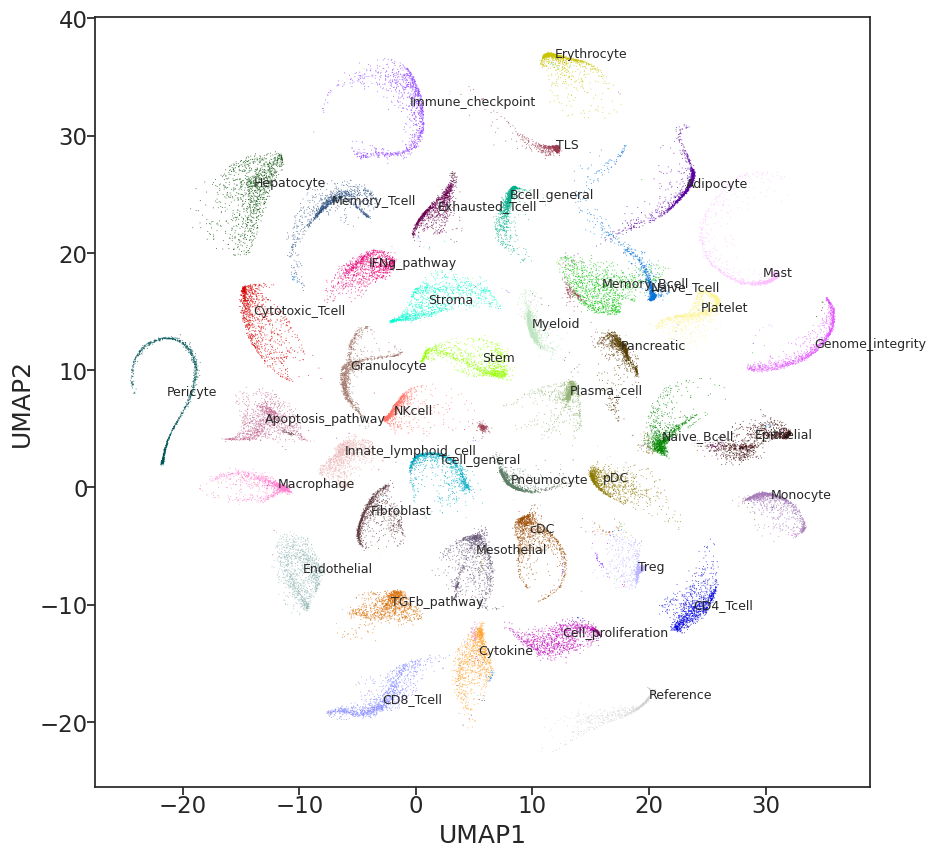

In [65]:
dfp = df2d[df2d.domain == 'ITRP']

fig, ax = plt.subplots(figsize=(10, 10))

x = 'UMAP1'
y = 'UMAP2'
hue = 'feature_name'

sns.scatterplot(data = dfp, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 0.5, 
                 ax=ax, legend=False)

mean = dfp.groupby(hue)[[x,y]].median()
for name in mean.index:
    s = mean.loc[name]
    ax.text(s[x], s[y], name,  fontdict={'fontsize':9})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

fig.savefig('cell_ITRP_UMAP_labelled.pdf', bbox_inches ='tight')

## UMAP Overlay

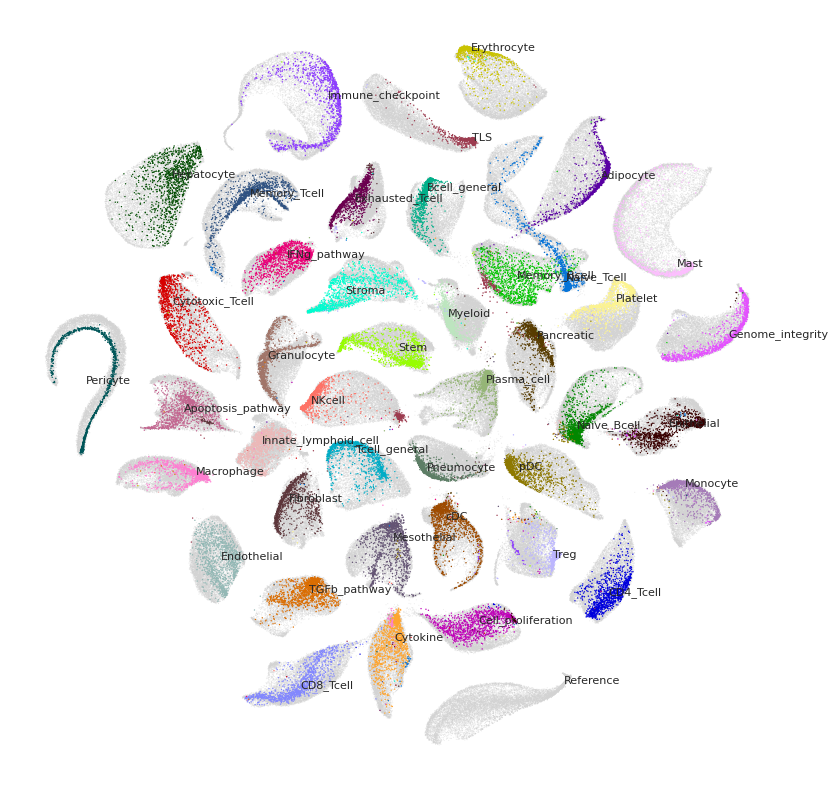

In [66]:
dfp1 = df2d[df2d.domain == 'TCGA']
dfp2 = df2d[df2d.domain == 'ITRP']

background_color = {i:'#d3d3d3' for i in hue_order}
fig, ax = plt.subplots(figsize=(10, 10))

x = 'UMAP1'
y = 'UMAP2'
hue = 'feature_name'

sns.scatterplot(data = dfp1, x = x, y = y, hue = hue,  alpha = 0.5,
                linewidth=0.0, hue_order = hue_order, palette=background_color, s = 0.5, 
                 ax=ax, legend=False)

sns.scatterplot(data = dfp2, x = x, y = y, hue = hue,  alpha = 1,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 1, 
                 ax=ax, legend=False)

mean = dfp2.groupby(hue)[[x,y]].median()
for name in mean.index:
    s = mean.loc[name]
    ax.text(s[x], s[y], name,  fontdict={'fontsize':8})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

plt.axis('off')

fig.savefig('cell_overlay_UMAP_labelled.pdf', bbox_inches ='tight')

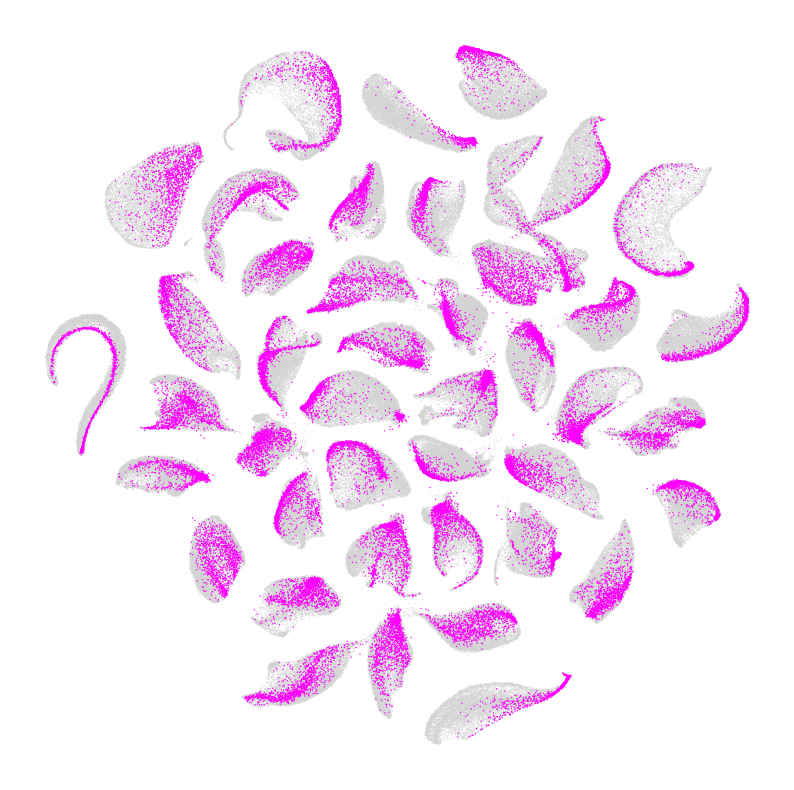

In [67]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


def add_legend(ax, markersize = 1):
    handles = []
    point1 = Line2D([0], [0], label='TCGA', marker='o', markersize=markersize, 
             markeredgecolor=list(background_color.values())[0], linestyle='',
                   markerfacecolor=list(background_color.values())[0],)
    
    point2 = Line2D([0], [0], label='ITRP', marker='o', markersize=markersize, 
             markeredgecolor=list(overlay_color.values())[0], linestyle='',
                   markerfacecolor=list(overlay_color.values())[0],)
    
    # add manual symbols to auto legend
    handles.extend([point1, point2])
    
    ax.legend(handles=handles, numpoints=5)
    

dfp1 = df2d[df2d.domain == 'TCGA']
dfp2 = df2d[df2d.domain == 'ITRP']

background_color = {i:'#d3d3d3' for i in hue_order}
overlay_color = {i:'#ff00ff' for i in hue_order}

fig, ax = plt.subplots(figsize=(10, 10))

x = 'UMAP1'
y = 'UMAP2'
hue = 'feature_name'

sns.scatterplot(data = dfp1, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=background_color, s = 0.5, 
                 ax=ax, legend=False)

sns.scatterplot(data = dfp2, x = x, y = y, hue = hue,  alpha = 1,
                linewidth=0.0, hue_order = hue_order, palette=overlay_color, s = 1, 
                 ax=ax, legend=False)

#add_legend(ax)

# mean = dfp1.groupby(hue)[[x,y]].median()
# for name in mean.index:
#     s = mean.loc[name]
#     ax.text(s[x], s[y], name,  fontdict={'fontsize':8})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

plt.axis('off')

fig.savefig('cell_overlay_UMAP_unlabelled.pdf', bbox_inches ='tight')
fig.savefig('cell_overlay_UMAP_unlabelled.jpg', bbox_inches ='tight', dpi=1000)

## PCA Overlay

In [ ]:
dfp1 = df2d[df2d.domain == 'TCGA']
dfp2 = df2d[df2d.domain == 'ITRP']

background_color = {i:'#d3d3d3' for i in hue_order}
overlay_color = {i:'#ff00ff' for i in hue_order}

fig, ax = plt.subplots(figsize=(10, 10))

x = 'PCA1'
y = 'PCA2'
hue = 'feature_name'

sns.scatterplot(data = dfp1, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=background_color, s = 0.5, 
                 ax=ax, legend=False)

sns.scatterplot(data = dfp2, x = x, y = y, hue = hue,  alpha = 1,
                linewidth=0.0, hue_order = hue_order, palette=overlay_color, s = 1, 
                 ax=ax, legend=False)

#add_legend(ax)

# mean = dfp1.groupby(hue)[[x,y]].median()
# for name in mean.index:
#     s = mean.loc[name]
#     ax.text(s[x], s[y], name,  fontdict={'fontsize':8})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.axis('off')

fig.savefig('cell_overlay_PCA_labelled.pdf', bbox_inches ='tight')
fig.savefig('cell_overlay_PCA_labelled.jpg', bbox_inches ='tight', dpi=1000)